In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
# from tensorflow.python.data import Dataset
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
% matplotlib inline
from time import time

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data = pd.read_csv('data/mnist_train_small.csv', header=None)

In [3]:
data = data.reindex(np.random.permutation(data.index))

In [36]:
tr_data = data.head(8000)
te_data = data.tail(2000)

In [5]:
tr_x = tr_data.loc[:,1:]/255
tr_y = pd.get_dummies(tr_data.loc[:,0]).astype(np.float64)

In [6]:
te_x = te_data.loc[:,1:]/255
te_y = pd.get_dummies(te_data.loc[:,0]).astype(np.float64)

In [37]:
tr_x = tr_data.loc[:,1:]/255
tr_y = tr_data.loc[:,0]

In [38]:
te_x = te_data.loc[:,1:]/255
te_y = te_data.loc[:,0]

In [396]:
lr = LogisticRegression(C=.1)
lr.fit(tr_x, np.argmax(tr_y.as_matrix(),axis=1))

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [397]:
prd = lr.predict(te_x)

In [398]:
metrics.accuracy_score( np.argmax(te_y.as_matrix(),axis=1), prd)

0.899

In [7]:
tf.reset_default_graph()
with tf.device('/cpu:0'):    
    x = tf.placeholder(tf.float32, (None,784), 'pixels')
    y = tf.placeholder(tf.float32, (None), 'targets')
    w = tf.get_variable('weights', (784, 10), tf.float32, initializer=tf.zeros_initializer())
    b = tf.get_variable('intercept', (1), tf.float32, initializer=tf.zeros_initializer())
    logits = tf.add(tf.matmul(x, w), b)
    h = tf.sigmoid(logits)
    lmbd=tf.constant(.0001)
    reg_term = tf.multiply(lmbd, tf.nn.l2_loss(w))
    loss = tf.reduce_mean(tf.add(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits), reg_term))
    my_opt = tf.train.AdamOptimizer(learning_rate=.1).minimize(loss)

In [8]:
stime = time()
num_epochs = 300
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(num_epochs):
        sess.run(my_opt, feed_dict={x:tr_x, y:tr_y})
    prd = sess.run(h, feed_dict={x:te_x})
    reg = sess.run(reg_term)
    ls = sess.run(loss, feed_dict={x:te_x, y:te_y})
    theta = sess.run(w)
prd = np.argmax(prd, axis=1)
print('Time taken =', time()-stime)

Time taken = 20.991775035858154


In [9]:
metrics.accuracy_score(np.argmax(te_y.as_matrix(), axis=1), prd)

0.894

In [13]:
tf.reset_default_graph()
num_epochs = 300
with tf.device('/cpu:0'):
    ds = tf.data.Dataset.from_tensor_slices((tr_x, tr_y))
#     ds = ds.shuffle(buffer_size=10000)
    ds = ds.batch(1000).repeat(num_epochs)
    x,y = ds.make_one_shot_iterator().get_next()
    w = tf.get_variable('weights', (784, 10), tf.float64, initializer=tf.zeros_initializer())
    b = tf.get_variable('intercept', (1), tf.float64, initializer=tf.zeros_initializer())
    logits = tf.add(tf.matmul(x, w), b)
    h = tf.sigmoid(logits)
    x_te = tf.data.Dataset.from_tensor_slices((te_x)).batch(2000).repeat(1).make_one_shot_iterator().get_next()
    pred = tf.sigmoid(tf.add(tf.matmul(x_te, w), b))
    lmbd=tf.constant(.0001, tf.float64)
    reg_term = tf.multiply(lmbd, tf.nn.l2_loss(w))
    loss = tf.reduce_mean(tf.add(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits), reg_term))
    my_opt = tf.train.AdamOptimizer(learning_rate=.1).minimize(loss)

In [14]:
stime = time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    try:
        while True:
            sess.run(my_opt)
    except tf.errors.OutOfRangeError:
        print('Training complete')
    prd = sess.run(pred)
    reg = sess.run(reg_term)
#     ls = sess.run(loss)
    theta = sess.run(w)
prd = np.argmax(prd, axis=1)
print('Time taken =', time()-stime)

Training complete
Time taken = 39.36195135116577


In [15]:
metrics.accuracy_score(np.argmax(te_y.as_matrix(), axis=1), prd)

0.876

In [21]:
tf.reset_default_graph()
with tf.device('/cpu:0'):    
    x = tf.placeholder_with_default(tr_x.astype(np.float32), (None,784), 'pixels')
    y = tf.placeholder(tf.float32, (None), 'targets')
    w = tf.get_variable('weights', (784, 10), tf.float32, initializer=tf.zeros_initializer())
    b = tf.get_variable('intercept', (1), tf.float32, initializer=tf.zeros_initializer())
    logits = tf.add(tf.matmul(x, w), b)
    h = tf.sigmoid(logits)
    lmbd=tf.constant(.0001)
    reg_term = tf.multiply(lmbd, tf.nn.l2_loss(w))
    loss = tf.reduce_mean(tf.add(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits), reg_term))
    my_opt = tf.train.AdamOptimizer(learning_rate=.1).minimize(loss)

In [140]:

def my_input_fn():

    x = tf.placeholder_with_default(tr_x.astype(np.float32), (None,784), 'pixels')
    y = tf.placeholder_with_default(np.array(tr_y)[:,np.newaxis], (None), 'targets')
    x = {'pixels':x}
    print('shape=', x['pixels'].shape)
    return x, y

In [141]:
def my_input_pred_fn():
#     x = tf.placeholder_with_default(te_x.astype(np.float32), (None,784), 'pixels')
#     y = tf.placeholder_with_default(np.array(te_y)[:,np.newaxis], (None), 'targets')
#     raw_features = {'pixels': te_x}
#     raw_targets = np.array(te_y)
#     ds = tf.data.Dataset.from_tensor_slices(({'pixels':x}, y))
#     ds = ds.repeat(1)
#     return ds.make_one_shot_iterator().get_next()

    x = tf.placeholder_with_default(te_x.astype(np.float32), (None,784), 'pixels')
    y = tf.placeholder_with_default(np.array(te_y)[:,np.newaxis], (None), 'targets')
    x = {'pixels':x}
    print('shape=', x['pixels'].shape)
    return x, y

In [167]:
stime = time()
my_opt = tf.train.AdagradOptimizer(learning_rate=.01)
my_opt = tf.contrib.estimator.clip_gradients_by_norm(my_opt, 5.0)
linear_classifier = tf.estimator.LinearClassifier(optimizer=my_opt, n_classes=10,
                                                  feature_columns=set([tf.feature_column.numeric_column('pixels', shape=784)]))
linear_classifier.train(steps=500,
                       input_fn = my_input_fn)
print('Time taken =', time()-stime)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpd0xbnoag', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe5d5e48b38>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
shape= (?, 784)
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpd0xbnoag/model.ckpt.
INFO:tensorflow:loss = 18420.736, step 

In [168]:
prd = linear_classifier.predict(input_fn=my_input_pred_fn)

In [169]:
i=0
res = []
for item in prd:
    one = item
    res += [one['class_ids'][0],]
    i += 1
    if i==2000:
        break

shape= (?, 784)
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpd0xbnoag/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [170]:
res = np.array(res)

In [171]:
metrics.accuracy_score(pd.get_dummies(te_y).values, pd.get_dummies(res).values)

0.901

In [362]:
reg

0.010899374

In [363]:
ls

0.08979064

In [364]:
(theta**2).sum()

217.98755

In [374]:
prd[:10]

array([2, 7, 6, 9, 1, 5, 3, 9, 2, 2])

In [375]:
np.argmax(te_y.as_matrix(), axis=1)[:10]

array([6, 7, 5, 9, 1, 5, 3, 9, 2, 2])

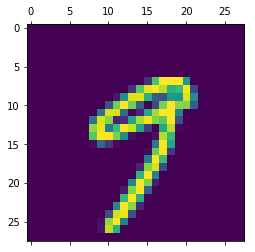

In [380]:
_, ax = plt.subplots()
ax.matshow(te_x.iloc[7].values.reshape(28, 28))
# ax.set_title("Label: %i" % te_y.loc[rand_example])
ax.grid(False)